# MNIST Classification
---
- Author: Diego Inácio
- GitHub: [github.com/diegoinacio](https://github.com/diegoinacio)
- Notebook: [MNIST_classification.ipynb](https://github.com/diegoinacio/computer-vision-notebooks/blob/master/Computer-Vision-Experiments/MNIST_classification.ipynb)

In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

import tensorflow as tf

In [2]:
plt.rcParams['figure.figsize'] = (20, 10)

## Read the dataset
---

In [3]:
mnist = tf.keras.datasets.mnist
[X_train, Y_train],[X_test, Y_test] = mnist.load_data()
X_train = X_train[..., None]
X_test = X_test[..., None]

# one hot for multi-class classification
# MNIST = 10 classes [0-9]
Y_train_oh = np.zeros((Y_train.size, 10))
Y_train_oh[np.arange(Y_train.size), Y_train] = 1
Y_test_oh = np.zeros((Y_test.size, 10))
Y_test_oh[np.arange(Y_test.size), Y_test] = 1

print('X_train:', X_train.shape)
print('Y_train:', Y_train.shape)
print('Y_train_oh:', Y_train_oh.shape)
print('X_test:', X_test.shape)
print('Y_test:', Y_test.shape)
print('Y_test_oh:', Y_test_oh.shape)

X_train: (60000, 28, 28, 1)
Y_train: (60000,)
Y_train_oh: (60000, 10)
X_test: (10000, 28, 28, 1)
Y_test: (10000,)
Y_test_oh: (10000, 10)


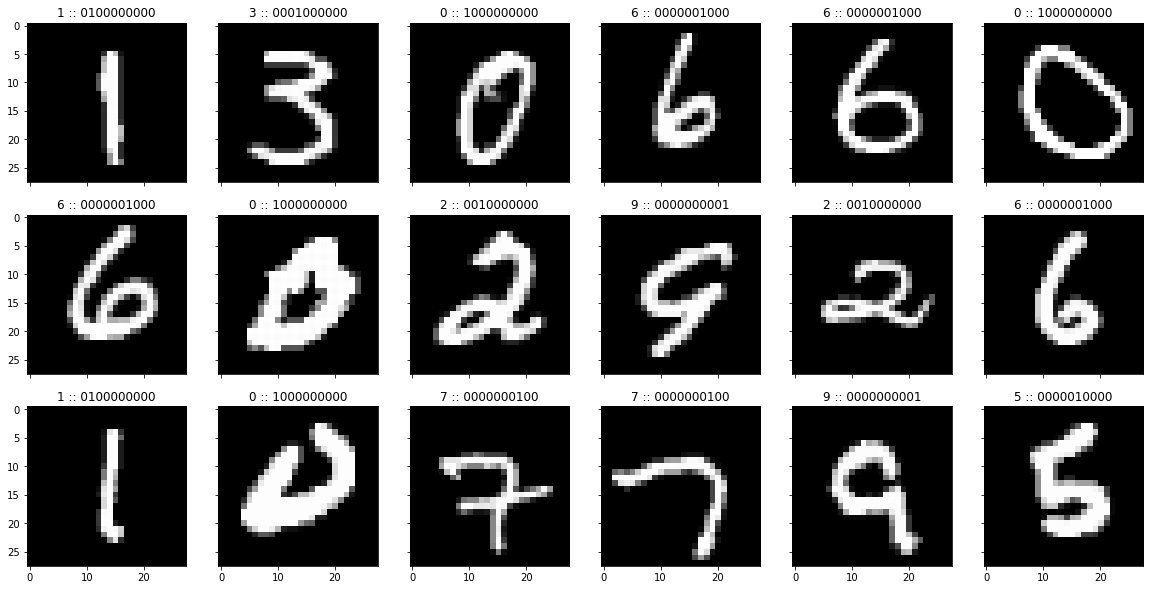

In [4]:
fig, AX = plt.subplots(3, 6, sharex=True, sharey=True)

np.random.seed(1234)
for ax in AX.ravel():
    rindex = np.random.randint(Y_train.size)
    img_show = X_train[rindex][...,0]
    ax.imshow(img_show, cmap='gray')
    # title label + one-hot
    title = f'{Y_train[rindex]} :: '
    title += ''.join([str(int(e)) for e in Y_train_oh[rindex]]) 
    ax.set_title(title)
plt.grid(False)

## Transform dataset
---

In [5]:
# Chanfe dtype to float32
X_train = X_train.astype(np.float32)
Y_train = Y_train.astype(np.float32)
X_test = X_test.astype(np.float32)
Y_test = Y_test.astype(np.float32)

# Change axes and normalization
X_train, Y_train = X_train/255, Y_train.reshape(-1, 1)
X_test, Y_test = X_test/255, Y_test.reshape(-1, 1)

# reshape Xs
x_train = X_train.reshape(-1, 28*28)
x_test = X_test.reshape(-1, 28*28)

print('X_train:', X_train.shape)
print('x_train:', x_train.shape)
print('Y_train:', Y_train.shape)
print('Y_train_oh:', Y_train_oh.shape)
print('X_test:', X_test.shape)
print('x_test:', x_test.shape)
print('Y_test:', Y_test.shape)
print('Y_test_oh:', Y_test_oh.shape)

X_train: (60000, 28, 28, 1)
x_train: (60000, 784)
Y_train: (60000, 1)
Y_train_oh: (60000, 10)
X_test: (10000, 28, 28, 1)
x_test: (10000, 784)
Y_test: (10000, 1)
Y_test_oh: (10000, 10)


# 1. Classification using *Shallow Neural Network*
---
One-hidden-layer neural network

In [6]:
EPOCHS = 20    # epochs
E = 5          # mini epoch
ALPHA = 0.005  # learning rate
BATCH = 1000   # batch size

# Number of neurons on the hidden layer
neurons = 32

# m is the number of examples
# n_x is the input size 28x28=784
m, n_x = x_train.shape

# modelSNN
modelSNN = tf.keras.Sequential([
    tf.keras.layers.Input(n_x),
    tf.keras.layers.Dense(neurons, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')
])

# Compile modelSNN
modelSNN.compile(
    loss='categorical_crossentropy',
    optimizer='SGD',
    lr=ALPHA,
    metrics=['accuracy']
)

# loss and accuracy storage
loss_plot = []; accA_plot = []

for epoch in range(EPOCHS + 1):
    # randomic batch definition
    rbatch = np.random.choice(Y_train.size, size=BATCH, replace=False)
    # training, metrics and storage
    modelSNN.fit(x_train[rbatch], Y_train_oh[rbatch], epochs=E, verbose=0)
    loss_plot += [e*100 for e in modelSNN.history.history['loss']]
    accA_plot += [e*100 for e in modelSNN.history.history['accuracy']]
    if (not epoch % (EPOCHS//5)) and (epoch != 0):
        print(f'epoch: {epoch*E:04d} | loss: {loss_plot[-1]:.3f} | accuracy: {accA_plot[-1]:06.2f} %')

epoch: 0020 | loss: 59.330 | accuracy: 084.40 %
epoch: 0040 | loss: 43.174 | accuracy: 087.60 %
epoch: 0060 | loss: 35.616 | accuracy: 089.90 %
epoch: 0080 | loss: 31.617 | accuracy: 091.50 %
epoch: 0100 | loss: 28.131 | accuracy: 092.30 %


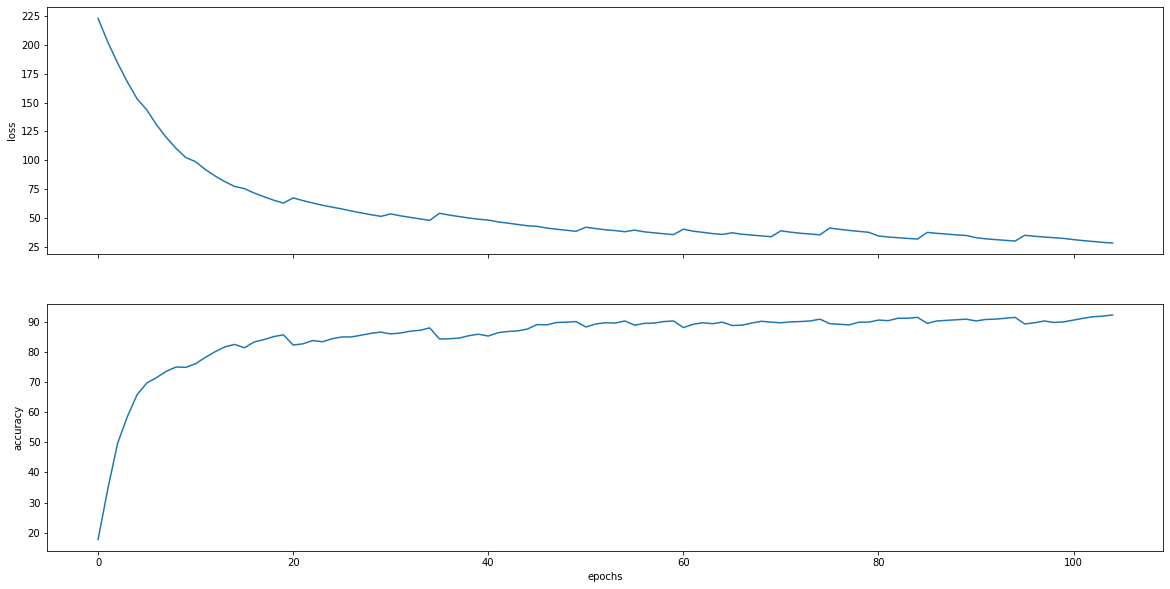

In [7]:
fig, [axA, axB] = plt.subplots(2, 1, sharex=True)

axA.plot(loss_plot)
axA.set_ylabel('loss')
axB.plot(accA_plot)
axB.set_ylabel('accuracy')

plt.xlabel('epochs')

plt.show()

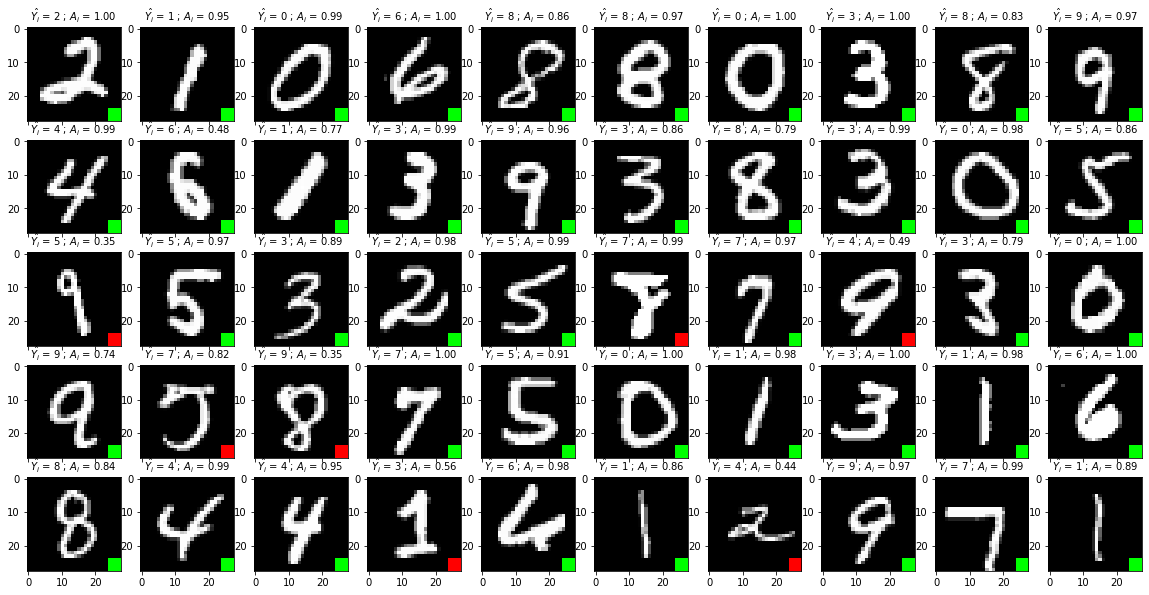

In [8]:
fig, AX = plt.subplots(5, 10, sharex=True)
AX = [b for a in AX for b in a]

pred = modelSNN.predict(x_test)

np.random.seed(1234)
for ax in AX:
    index = np.random.randint(Y_test.size)
    # Predict
    A_ = pred[index]
    Y_ = np.argmax(A_)
    # Prepare image to show
    img_show = np.ones((*x_test[index].shape, 3))
    img_show *= x_test[index][..., None]
    img_show = img_show.reshape(28, 28, 3)
    # Green square: classified correctly
    # Red square: classified wrongly
    if Y_ == Y_test[index]:
        img_show[-4:, -4:] = (0, 1, 0)
    else:
        img_show[-4:, -4:] = (1, 0, 0)
    ax.imshow(img_show)
    ax.set_title(r'$\hat{Y_i}$ = ' + str(Y_) + r' ; $A_i$ = {:.02f}'.format(float(A_[Y_])), fontsize=10)

In [9]:
print('Validation')
pred1 = modelSNN.predict(x_test)
print('Test:', np.sum((Y_test_oh - pred1)**2, axis=1).mean())
pred2 = modelSNN.predict(x_train)
print('Train:', np.sum((Y_train_oh - pred2)**2, axis=1).mean())

Validation
Test: 0.1430149062364789
Train: 0.15132292483922116


# 2. Classification using *Convolutional Neural Network*
---

In [10]:
# Get dimensions
N1, N2, C = X_train[0].shape

# Model
modelCNN = tf.keras.Sequential([
    tf.keras.layers.Input(X_train[0].shape),
    tf.keras.layers.Conv2D(32, 3, activation='relu'),
    tf.keras.layers.Conv2D(64, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=2),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(N1*N2, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(10, activation='softmax')
])

modelCNN.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 24, 64)        18496     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 12, 12, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 12, 12, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 9216)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 784)               7226128   
_________________________________________________________________
dropout_1 (Dropout)          (None, 784)              

In [11]:
modelCNN.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

modelCNN.fit(X_train, Y_train_oh, epochs=5)

Train on 60000 samples
Epoch 1/5
60000/60000 [==============================] - 53s 880us/sample - loss: 0.1263 - accuracy: 0.9608
Epoch 2/5
60000/60000 [==============================] - 53s 883us/sample - loss: 0.0511 - accuracy: 0.9835
Epoch 3/5
60000/60000 [==============================] - 55s 909us/sample - loss: 0.0359 - accuracy: 0.9888
Epoch 4/5
60000/60000 [==============================] - 55s 924us/sample - loss: 0.0266 - accuracy: 0.9916
Epoch 5/5
60000/60000 [==============================] - 53s 891us/sample - loss: 0.0227 - accuracy: 0.9928


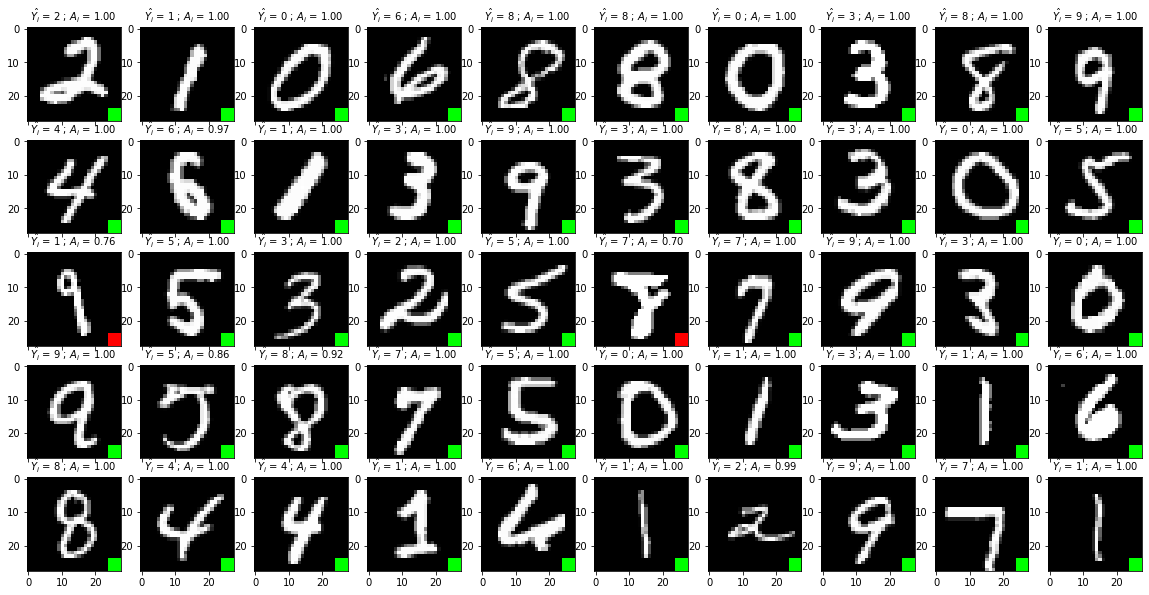

In [12]:
fig, AX = plt.subplots(5, 10, sharex=True)
AX = [b for a in AX for b in a]

pred = modelCNN.predict(X_test)

np.random.seed(1234)
for ax in AX:
    index = np.random.randint(Y_test.size)
    # Predict
    A_ = pred[index]
    Y_ = np.argmax(A_)
    # Prepare image to show
    img_show = np.ones((N1, N2, 3))
    img_show *= X_test[index]
    # Green square: classified correctly
    # Red square: classified wrongly
    if Y_ == Y_test[index]:
        img_show[-4:, -4:] = (0, 1, 0)
    else:
        img_show[-4:, -4:] = (1, 0, 0)
    ax.imshow(img_show)
    ax.set_title(r'$\hat{Y_i}$ = ' + str(Y_) + r' ; $A_i$ = {:.02f}'.format(float(A_[Y_])), fontsize=10)

In [13]:
print('Validation')
pred1 = modelCNN.predict(X_test)
print('Test:', np.sum((Y_test_oh - pred1)**2, axis=1).mean())
pred2 = modelCNN.predict(X_train)
print('Train:', np.sum((Y_train_oh - pred2)**2, axis=1).mean())

Validation
Test: 0.013602644419278455
Train: 0.0024918568558348563
